## Lab 9 Graph processing with Spark GraphFrames
### CSCI E-63 Big Data Analytics, Spring 2023
Stephen Camera-Murray, TA   
2023-04-01

<img align="left" src="https://miro.medium.com/v2/resize:fit:506/1*V7wAiybYYV8NA6qrhi8jVA.png" alt="Graph Image" width="400"/>

## Please Remind Me to Hit Record!!
<img align="left" src="https://media3.giphy.com/media/26gsubAykLhIDSKKA/giphy.gif?cid=ecf05e47pzt7dr02nt6rpezz1na151nn8ehvutf3qf3ol2x7&rid=giphy.gif&ct=g" alt="Record" width="400"/>

Graph analysis has become a more and more prominent data analysis technique for both social network analysis (community mining and modeling author types) and recommender systems.

On this machine I have two environmental variables set:
- PYSPARK_DRIVER_PYTHON=jupyter
- PYSPARK_DRIVER_PYTHON_OPTS=notebook

##### Steps:
1. Before starting this notebook, install graphframes in a terminal window:
```
pip install graphframes
```

2. Start this notebook with the following command:
```
pyspark --packages graphframes:graphframes:0.8.2-spark3.2-s_2.12
```

A GraphFrame is always created from a vertex DataFrame (e.g. users) and an edges DataFrame (e.g. relationships between users). The schema of both DataFrames has some mandatory columns. The vertex DataFrame must contain a column named `id` that stores unique vertex IDs. The edges DataFrame must contain a column named `src` that stores the source of the edge and a column named `dst` that stores the destination of the edge. All other columns are optional and can be added depending on one’s needs.

In [1]:
from pyspark import *
from pyspark.sql import *
# You will need the following line if running a standalone script
#spark = SparkSession.builder.appName('fun').getOrCreate()
from graphframes import *

In [2]:
# Supress warnings
import warnings
warnings.filterwarnings('ignore')

Create DataFrames with `vertices` and `edges` with mandatory columns. Then create the GraphFrame `g`

In [3]:
vertices = spark.createDataFrame([('1', 'Carter', 'Derrick', 50), 
                                  ('2', 'May', 'Derrick', 26),
                                 ('3', 'Mills', 'Jeff', 80),
                                  ('4', 'Hood', 'Robert', 65),
                                  ('5', 'Banks', 'Mike', 93),
                                 ('98', 'Berg', 'Tim', 28),
                                 ('99', 'Page', 'Allan', 16)],
                                 ['id', 'name', 'firstname', 'age'])

In [4]:
edges = spark.createDataFrame([('1', '2', 'friend'), 
                               ('2', '1', 'friend'),
                              ('3', '1', 'friend'),
                              ('1', '3', 'friend'),
                               ('2', '3', 'follows'),
                               ('3', '4', 'friend'),
                               ('4', '3', 'friend'),
                               ('5', '3', 'friend'),
                               ('3', '5', 'friend'),
                               ('4', '5', 'follows'),
                              ('98', '99', 'friend'),
                              ('99', '98', 'friend')],
                              ['src', 'dst', 'type'])

In [5]:
g = GraphFrame(vertices, edges)

Take a look at the DataFrames

In [6]:
# Check the number of edges of each vertex g.degrees.show()
g.vertices.show() 
g.edges.show()

+---+------+---------+---+
| id|  name|firstname|age|
+---+------+---------+---+
|  1|Carter|  Derrick| 50|
|  2|   May|  Derrick| 26|
|  3| Mills|     Jeff| 80|
|  4|  Hood|   Robert| 65|
|  5| Banks|     Mike| 93|
| 98|  Berg|      Tim| 28|
| 99|  Page|    Allan| 16|
+---+------+---------+---+

+---+---+-------+
|src|dst|   type|
+---+---+-------+
|  1|  2| friend|
|  2|  1| friend|
|  3|  1| friend|
|  1|  3| friend|
|  2|  3|follows|
|  3|  4| friend|
|  4|  3| friend|
|  5|  3| friend|
|  3|  5| friend|
|  4|  5|follows|
| 98| 99| friend|
| 99| 98| friend|
+---+---+-------+



g.vertices.show()
g.edges.show()## Check the number of edges of each vertex
g.degrees.show()

The GraphFrame we just created is a directed one, and can be visualized as follows:
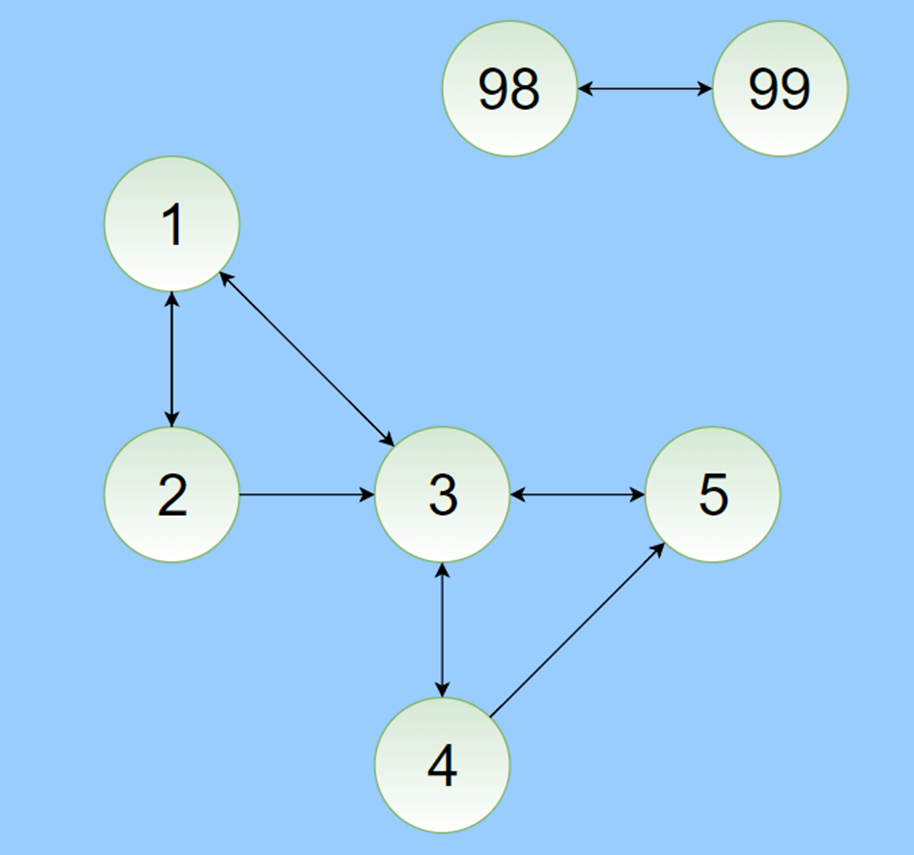

#### Directed vs undirected edges
Undirected graphs have edges that do not have a direction. The edges indicate a two-way relationship, in that each edge can be traversed in both directions.

If your DataFrame only consist of two-way directed edges, you may be interested in analyzing undirected edges. You can convert your graph by mapping a function over the edges DataFrame that deletes the row `if src ≥ dst` (or the other way around). In GraphX you could use `to_undirected()` to create a deep, undirected copy of the Graph. GraphFrames does not support this functionality.
An easy example to work around this missing functionality can be found in the following code snippet. Please note that the ‘follows’ edge doesn’t really make sense in an undirected graph, since it doesn’t represent a two-way relationship.

In [7]:
copy = edges
from pyspark.sql.functions import udf

@udf("string")
def to_undir(src, dst):
    if src >= dst:
        return 'Delete'
    else : 
        return 'Keep'
    
copy.withColumn('undir', to_undir(copy.src, copy.dst))\
.filter('undir == "Keep"').drop('undir').show()

+---+---+-------+
|src|dst|   type|
+---+---+-------+
|  1|  2| friend|
|  1|  3| friend|
|  2|  3|follows|
|  3|  4| friend|
|  3|  5| friend|
|  4|  5|follows|
| 98| 99| friend|
+---+---+-------+



#### Filtering and connected components
A GraphFrame itself can not be filtered, but DataFrames deducted from a Graph can. Consequently, the filter-function (or any other function) can be used just as you would use it with DataFrames. The only trap-hole might be the correct use of quotation marks: the whole condition should be quoted. The examples below should clarify this.

In [8]:
g.vertices.filter("age > 30").show()

+---+------+---------+---+
| id|  name|firstname|age|
+---+------+---------+---+
|  1|Carter|  Derrick| 50|
|  3| Mills|     Jeff| 80|
|  4|  Hood|   Robert| 65|
|  5| Banks|     Mike| 93|
+---+------+---------+---+



In [9]:
g.inDegrees.filter("inDegree >= 2").sort("inDegree", ascending=False).show()

+---+--------+
| id|inDegree|
+---+--------+
|  3|       4|
|  1|       2|
|  5|       2|
+---+--------+



In [10]:
g.edges.filter('type == "friend"').show()

+---+---+------+
|src|dst|  type|
+---+---+------+
|  1|  2|friend|
|  2|  1|friend|
|  3|  1|friend|
|  1|  3|friend|
|  3|  4|friend|
|  4|  3|friend|
|  5|  3|friend|
|  3|  5|friend|
| 98| 99|friend|
| 99| 98|friend|
+---+---+------+



#### Connected Components
A connected component of a graph is a subgraph in which any two vertices are connected to each other by one or more edges, and which is connected to no additional vertices in the supergraph. In the (undirected) example below there are three connected components. Connected components detection can be interesting for clustering, but also to make your computations more efficient.
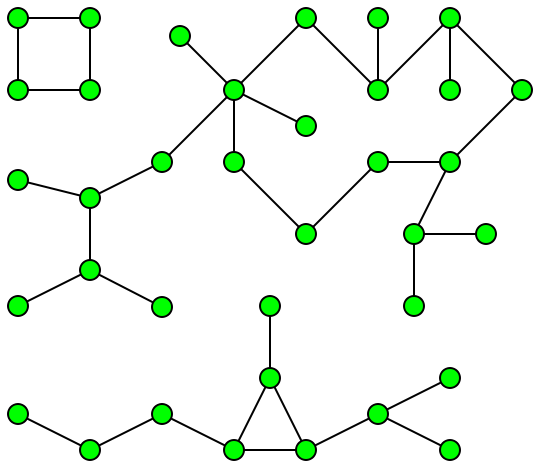

GraphFrames requires you to set a directory where it can save checkpoints. Create such a folder in your working directory and drop the following line (where `graphframes_cps` is your new folder) in Jupyter to set the checkpoint directory.

In [11]:
sc.setCheckpointDir('graphframes_cps')

Then, the connected components can easily be computed with the `connectedComponents` -function. The function computes the connected component membership of each vertex and returns a graph with each vertex assigned a component ID.

Our mini-graph has two connected components, which are described for each vertex in the component column.

In [12]:
g.connectedComponents().show()

+---+------+---------+---+------------+
| id|  name|firstname|age|   component|
+---+------+---------+---+------------+
|  1|Carter|  Derrick| 50|154618822656|
|  2|   May|  Derrick| 26|154618822656|
|  3| Mills|     Jeff| 80|154618822656|
|  4|  Hood|   Robert| 65|154618822656|
|  5| Banks|     Mike| 93|154618822656|
| 98|  Berg|      Tim| 28|317827579904|
| 99|  Page|    Allan| 16|317827579904|
+---+------+---------+---+------------+



#### Strongly connected components
Compute the strongly connected component (SCC) of each vertex and return a graph with each vertex assigned to the SCC containing that vertex.

With GraphFrames 0.3.0 and later releases, the default Connected Components algorithm requires setting a Spark checkpoint directory.

In [13]:
sc.setCheckpointDir('stronglyconnected_cps')

In [14]:
result = g.stronglyConnectedComponents(maxIter=10)
result.select("id","name", "component").orderBy("component").show()

23/04/01 01:35:03 WARN BlockManager: Block rdd_306_0 already exists on this machine; not re-adding it
+---+------+------------+
| id|  name|   component|
+---+------+------------+
|  5| Banks|154618822656|
|  4|  Hood|154618822656|
|  2|   May|154618822656|
|  1|Carter|154618822656|
|  3| Mills|154618822656|
| 98|  Berg|317827579904|
| 99|  Page|317827579904|
+---+------+------------+



#### Motif finding
Finding motifs helps to execute queries to discover structural patterns in graphs. Network motifs are patterns that occur repeatedly in the graph and represent the relationships between the vertices. GraphFrames motif finding uses a declarative Domain Specific Language (DSL) for expressing structural queries.
The query can be invoked by using the `find` -function, where the `motif` (passed in quotation marks) is expressed as the first parameter of the function.
The following example will search for pairs of vertices `a,b` connected by edge `e` and pairs of vertices `b,a` connected by edge `e2`. It will return a DataFrame of all such structures in the graph, with columns for each of the named elements (vertices or edges) in the `motif`.

In [15]:
g.find("(a)-[e]->(b); (b)-[e2]->(a)").show()

+--------------------+----------------+--------------------+----------------+
|                   a|               e|                   b|              e2|
+--------------------+----------------+--------------------+----------------+
|{2, May, Derrick,...|  {2, 1, friend}|{1, Carter, Derri...|  {1, 2, friend}|
|{3, Mills, Jeff, 80}|  {3, 1, friend}|{1, Carter, Derri...|  {1, 3, friend}|
|{1, Carter, Derri...|  {1, 2, friend}|{2, May, Derrick,...|  {2, 1, friend}|
|{1, Carter, Derri...|  {1, 3, friend}|{3, Mills, Jeff, 80}|  {3, 1, friend}|
|{4, Hood, Robert,...|  {4, 3, friend}|{3, Mills, Jeff, 80}|  {3, 4, friend}|
|{5, Banks, Mike, 93}|  {5, 3, friend}|{3, Mills, Jeff, 80}|  {3, 5, friend}|
|{3, Mills, Jeff, 80}|  {3, 4, friend}|{4, Hood, Robert,...|  {4, 3, friend}|
|{3, Mills, Jeff, 80}|  {3, 5, friend}|{5, Banks, Mike, 93}|  {5, 3, friend}|
|{99, Page, Allan,...|{99, 98, friend}| {98, Berg, Tim, 28}|{98, 99, friend}|
| {98, Berg, Tim, 28}|{98, 99, friend}|{99, Page, Allan,...|{99,

If edges and/or vertices are anonymous, they won’t be displayed in the resulting DataFrame. Motifs can be joined by a semicolon and can be negated with a exclamation mark. More details about the Domain Specific Language can be found in GraphFrames documentation.
https://graphframes.github.io/graphframes/docs/_site/user-guide.html#:~:text=Motif%20finding%20refers%20to%20searching,by%20edges%20in%20both%20directions.

As an example we can try to find the mutual friends for any pair of users `a` and `c`. In order to be a mutual friend `b`, `b` must be a friend with both `a` and `c` (and not just followed by `c`, for example).

In [16]:
mutualFriends = g.find("(a)-[]->(b); (b)-[]->(c); (c)-[]->(b); (b)-[]->(a)")\
.dropDuplicates()

In [17]:
mutualFriends.show()

+--------------------+--------------------+--------------------+
|                   a|                   b|                   c|
+--------------------+--------------------+--------------------+
|{4, Hood, Robert,...|{3, Mills, Jeff, 80}|{4, Hood, Robert,...|
|{3, Mills, Jeff, 80}|{1, Carter, Derri...|{2, May, Derrick,...|
|{4, Hood, Robert,...|{3, Mills, Jeff, 80}|{1, Carter, Derri...|
|{5, Banks, Mike, 93}|{3, Mills, Jeff, 80}|{1, Carter, Derri...|
|{3, Mills, Jeff, 80}|{1, Carter, Derri...|{3, Mills, Jeff, 80}|
|{5, Banks, Mike, 93}|{3, Mills, Jeff, 80}|{5, Banks, Mike, 93}|
|{5, Banks, Mike, 93}|{3, Mills, Jeff, 80}|{4, Hood, Robert,...|
|{1, Carter, Derri...|{2, May, Derrick,...|{1, Carter, Derri...|
|{1, Carter, Derri...|{3, Mills, Jeff, 80}|{4, Hood, Robert,...|
|{2, May, Derrick,...|{1, Carter, Derri...|{3, Mills, Jeff, 80}|
|{1, Carter, Derri...|{3, Mills, Jeff, 80}|{5, Banks, Mike, 93}|
|{1, Carter, Derri...|{3, Mills, Jeff, 80}|{1, Carter, Derri...|
|{99, Page, Allan,...| {9

To query all the mutual friends between 2 and 3 we can filter the DataFrame.

In [18]:
mutualFriends.filter('a.id == 2 and c.id == 3').show()

+--------------------+--------------------+--------------------+
|                   a|                   b|                   c|
+--------------------+--------------------+--------------------+
|{2, May, Derrick,...|{1, Carter, Derri...|{3, Mills, Jeff, 80}|
+--------------------+--------------------+--------------------+



The `b`-column shows all the mutual friends (just one in this case).

#### TriangleCount
TriangleCount counts the number of triangles passing through each vertex in this graph. A triangle can be defined as a group of three vertices that is interrelated, i.e. a has an edge to b, b has an edge to c, and c has an edge to a. The example below shows a graph with two triangles.
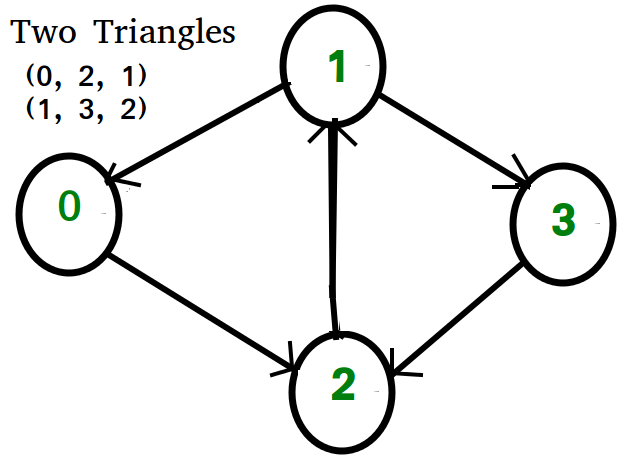

In the GraphFrames package you can count the number of triangles passing through each vertex by invoking the `triangleCount`-function. Note that our simple example has only two triangles in total. Triangles are used for various tasks for real‐life networks, including community discovery, link prediction, and spam filtering.

In [19]:
g.triangleCount().show()

+-----+---+------+---------+---+
|count| id|  name|firstname|age|
+-----+---+------+---------+---+
|    2|  3| Mills|     Jeff| 80|
|    1|  1|Carter|  Derrick| 50|
|    1|  2|   May|  Derrick| 26|
|    0| 98|  Berg|      Tim| 28|
|    0| 99|  Page|    Allan| 16|
|    1|  5| Banks|     Mike| 93|
|    1|  4|  Hood|   Robert| 65|
+-----+---+------+---------+---+



The first column `count` tells how many triangles touch a particular node. 

#### PageRank
PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is. The underlying assumption is that more important websites are likely to receive more links from other websites.

The PageRank algorithm holds that an imaginary surfer who is randomly clicking on links will eventually stop clicking. The probability, at any step, that the person will continue is a damping factor. The damping factor can be be set by changing the resetProbability parameter. Other important parameters are the tolerance (`tol`) and the maximum number of iterations (`maxIter`).

#### From the Docs
https://graphframes.github.io/graphframes/docs/_site/user-guide.html

There are two implementations of PageRank.

The first one uses the org.apache.spark.graphx.graph interface with aggregateMessages and runs PageRank for a fixed number of iterations. This can be executed by setting ```maxIter```.

The second implementation uses the org.apache.spark.graphx.Pregel interface and runs PageRank until convergence and this can be run by setting ```tol```.
Both implementations support non-personalized and personalized PageRank, where setting a sourceId personalizes the results for that vertex.

See [Wikipedia](https://en.wikipedia.org/wiki/PageRank) for background.

In [20]:
pr = g.pageRank(resetProbability=0.15, tol=0.01)
## look at the pagerank score for every vertex
pr.vertices.show()
## look at the weight of every edge
pr.edges.show()

+---+------+---------+---+------------------+
| id|  name|firstname|age|          pagerank|
+---+------+---------+---+------------------+
|  3| Mills|     Jeff| 80| 1.853919642738813|
| 98|  Berg|      Tim| 28|1.0225331112091938|
| 99|  Page|    Allan| 16|1.0225331112091938|
|  5| Banks|     Mike| 93|0.9703579134677663|
|  1|Carter|  Derrick| 50|0.9055074972891308|
|  4|  Hood|   Robert| 65|0.6873519241384106|
|  2|   May|  Derrick| 26|0.5377967999474921|
+---+------+---------+---+------------------+

+---+---+-------+------------------+
|src|dst|   type|            weight|
+---+---+-------+------------------+
|  3|  5| friend|0.3333333333333333|
|  3|  1| friend|0.3333333333333333|
|  3|  4| friend|0.3333333333333333|
| 98| 99| friend|               1.0|
| 99| 98| friend|               1.0|
|  5|  3| friend|               1.0|
|  1|  3| friend|               0.5|
|  1|  2| friend|               0.5|
|  4|  3| friend|               0.5|
|  4|  5|follows|               0.5|
|  2|  3|fol

#### Breadth-first search (BFS)
Breadth-first search (BFS) finds the shortest path(s) from one vertex (or a set of vertices) to another vertex (or a set of vertices). The beginning and end vertices are specified as Spark DataFrame expressions.

You can read more here: https://www.geeksforgeeks.org/breadth-first-search-or-bfs-for-a-graph/

The following code snippets uses BFS to find path between vertex with the name "Mills" to a vertex with `age < 32`.

In [21]:
paths = g.bfs("name = 'Mills'", "age < 32")
paths.show()

+--------------------+--------------+--------------------+--------------+--------------------+
|                from|            e0|                  v1|            e1|                  to|
+--------------------+--------------+--------------------+--------------+--------------------+
|{3, Mills, Jeff, 80}|{3, 1, friend}|{1, Carter, Derri...|{1, 2, friend}|{2, May, Derrick,...|
+--------------------+--------------+--------------------+--------------+--------------------+



#### Label Propagation Algorithm (LPA)
Static Label Propagation Algorithm is used for detecting communities in networks.

Each node in the network is initially assigned to its own community. At every superstep, nodes send their community affiliation to all neighbors and update their state to the mode community affiliation of incoming messages.

LPA is a standard community detection algorithm for graphs. It is very inexpensive computationally, although (1) convergence is not guaranteed and (2) one can end up with trivial solutions (all nodes are identified into a single community)).

The process has 5 steps:

1. Initialize the labels at all nodes in the network. For a given node x, Cx (0) = x.

2. Set t = 1.

3. Arrange the nodes in the network in a random order and set it to X.

4. For each x ∈ X chosen in that specific order, let Cx(t) = f(Cxi1(t), ...,Cxim(t),Cxi(m+1) (t − 1), ...,Cxik (t − 1)). Here returns the label occurring with the highest frequency among neighbours. Select a label at random if there are multiple highest frequency labels.

5. If every node has a label that the maximum number of their neighbours have, then stop the algorithm. Else, set t = t + 1 and go to (3).

In [22]:
g.vertices.show()
g.edges.show()

+---+------+---------+---+
| id|  name|firstname|age|
+---+------+---------+---+
|  1|Carter|  Derrick| 50|
|  2|   May|  Derrick| 26|
|  3| Mills|     Jeff| 80|
|  4|  Hood|   Robert| 65|
|  5| Banks|     Mike| 93|
| 98|  Berg|      Tim| 28|
| 99|  Page|    Allan| 16|
+---+------+---------+---+

+---+---+-------+
|src|dst|   type|
+---+---+-------+
|  1|  2| friend|
|  2|  1| friend|
|  3|  1| friend|
|  1|  3| friend|
|  2|  3|follows|
|  3|  4| friend|
|  4|  3| friend|
|  5|  3| friend|
|  3|  5| friend|
|  4|  5|follows|
| 98| 99| friend|
| 99| 98| friend|
+---+---+-------+



In [23]:
result = g.labelPropagation(maxIter=5)
result.select("id", "label").show()

+---+-------------+
| id|        label|
+---+-------------+
|  3| 420906795008|
| 98| 326417514496|
| 99| 317827579904|
|  5| 154618822656|
|  1|1623497637888|
|  4| 154618822656|
|  2| 420906795008|
+---+-------------+



#### Shortest paths
Computes shortest paths from each vertex to the given set of landmark vertices, where landmarks are specified by vertex ID. Note that this takes edge direction into account.

In [26]:
from graphframes.examples import Graphs
# Get example graph
g = Graphs(sqlContext).friends()

# Check the number of edges of each vertex g.degrees.show()
g.vertices.show() 
g.edges.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
+---+-------+---+

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
+---+---+------------+



In [27]:
results = g.shortestPaths(landmarks=["a", "d"])
results.select("id", "distances").show()

+---+----------------+
| id|       distances|
+---+----------------+
|  f|              {}|
|  e|{a -> 2, d -> 1}|
|  d|{a -> 1, d -> 0}|
|  c|              {}|
|  b|              {}|
|  a|        {a -> 0}|
+---+----------------+



#### Saving and loading GraphFrames
Since GraphFrames are built around DataFrames, they automatically support saving and loading to and from the same set of datasources

In [29]:
from graphframes.examples import Graphs
g = Graphs(sqlContext).friends()  # Get example graph

# Save vertices and edges as Parquet to some location.
g.vertices.write.parquet("par_vertices")
g.edges.write.parquet("par_edges")

# Load the vertices and edges back.
sameV = sqlContext.read.parquet("par_vertices")
sameE = sqlContext.read.parquet("par_edges")

# Create an identical GraphFrame.
sameG = GraphFrame(sameV, sameE)

In [31]:
# Save vertices and edges as CSV files to some location.
g.vertices.write.csv("csv_vertices", header=True)
g.edges.write.csv("csv_edges", header=True)

# Load the vertices and edges back.
newV = sqlContext.read.csv("csv_vertices", header=True)
newE = sqlContext.read.csv("csv_edges", header=True)

# Create an identical GraphFrame.
newV.show()
newE.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
+---+-------+---+

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
+---+---+------------+

